# Explore Zillow timeseries using Prophet and Linear Regression

## Ingest

In [0]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns; sns.set(color_codes=True)
from sklearn.cluster import KMeans
color = sns.color_palette()
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [0]:
df = pd.read_csv("https://raw.githubusercontent.com/noahgift/real_estate_ml/master/data/Zip_Zhvi_SingleFamilyResidence_2018.csv")


## EDA

In [0]:
df.describe()

,RegionID,RegionName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,...,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12
count,15508.000,15508.000,15508.000,14338.000,14338.000,14338.000,14338.000,14338.000,14338.000,14338.000,...,15508.000,15508.000,15508.000,15508.000,15508.000,15508.000,15508.000,15508.000,15508.000,15508.000
mean,80789.618,47683.566,7754.500,115889.866,116007.379,116123.051,116235.493,116358.920,116501.681,116689.315,...,279359.582,280672.685,282148.749,283446.447,284466.282,285500.200,286717.307,288029.320,289187.510,290106.635
std,31521.485,29008.034,4476.918,85115.825,85264.209,85413.118,85566.676,85744.243,85958.867,86230.630,...,361868.364,361360.576,363102.089,365301.815,366277.876,367095.613,366772.521,364624.171,361143.146,359132.687
min,58196.000,1001.000,1.000,11300.000,11500.000,11600.000,11800.000,11800.000,12000.000,12100.000,...,21700.000,21700.000,22100.000,22200.000,22000.000,21800.000,21700.000,21500.000,21600.000,21900.000
25%,67215.000,22199.000,3877.750,66700.000,66800.000,66925.000,67100.000,67200.000,67300.000,67500.000,...,128300.000,128800.000,129675.000,130300.000,131100.000,131900.000,132900.000,134000.000,135100.000,135600.000
50%,77886.500,45792.500,7754.500,96500.000,96700.000,96750.000,96900.000,96900.000,97000.000,97150.000,...,191100.000,192150.000,193400.000,194600.000,195700.000,196900.000,198100.000,199600.000,201100.000,202150.000
75%,90314.250,74010.250,11631.250,140500.000,140600.000,140600.000,140800.000,141000.000,141100.000,141300.000,...,310750.000,312300.000,314325.000,316100.000,317425.000,318325.000,319800.000,321200.000,322425.000,323900.000
max,753844.000,99901.000,15508.000,3676700.000,3704200.000,3729600.000,3754600.000,3781800.000,3813500.000,3849600.000,...,17724700.000,17408900.000,17450500.000,17722800.000,18006700.000,18273800.000,18331900.000,18131900.000,17594900.000,17119600.000


#### Clean Up DataFrame
Rename RegionName to ZipCode and Change Zip Code to String 

In [0]:
df.rename(columns={"RegionName":"ZipCode"}, inplace=True)
df["ZipCode"]=df["ZipCode"].map(lambda x: "{:.0f}".format(x))
df["RegionID"]=df["RegionID"].map(lambda x: "{:.0f}".format(x))
df.head()

,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12
0,84654,60657,Chicago,IL,Chicago-Naperville-Elgin,Cook County,1,334200.000,335400.000,336500.000,...,1037400,1038700,1041500,1042800,1042900,1044400,1047800,1049700,1048300,1047900
1,91982,77494,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,2,210400.000,212200.000,212200.000,...,330400,332700,334500,335900,337000,338300,338400,336900,336000,336500
2,84616,60614,Chicago,IL,Chicago-Naperville-Elgin,Cook County,3,498100.000,500900.000,503100.000,...,1317900,1321100,1325300,1323800,1321200,1320700,1319500,1318800,1319700,1323300
3,93144,79936,El Paso,TX,El Paso,El Paso County,4,77300.000,77300.000,77300.000,...,120800,121300,122200,123000,123600,124500,125600,126300,126800,127400
4,91940,77449,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,5,95400.000,95600.000,95800.000,...,175500,176400,176900,176900,177300,178000,178500,179300,180200,180700


In [0]:
median_prices = df.median()
#sf_prices = df["City"] == "San Francisco".median()


**Median USA Prices December, 2018**

In [0]:
median_prices.tail()

2018-08   196900.000
2018-09   198100.000
2018-10   199600.000
2018-11   201100.000
2018-12   202150.000
dtype: float64

In [0]:
sf_df = df[df["City"] == "San Francisco"].median()
df_comparison = pd.concat([sf_df,median_prices], axis=1)
df_comparison.columns = ["San Francisco","Median USA"]
df_comparison.tail()


,San Francisco,Median USA
2018-08,1828600.000,196900.000
2018-09,1823200.000,198100.000
2018-10,1823700.000,199600.000
2018-11,1813400.000,201100.000
2018-12,1806000.000,202150.000


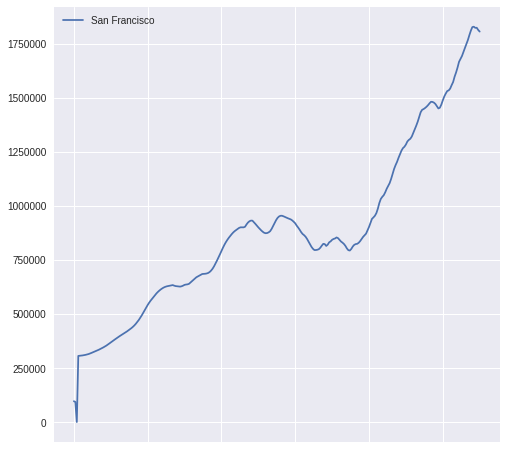

In [0]:
df_comparison[['San Francisco']].plot(x = df_comparison.index,figsize = (8,8))

## Modelling

###Using Prophet from Facebook for timeseries regession

In [0]:
from fbprophet import Prophet
df_ts = df_comparison.iloc[3:,:][['San Francisco']]
df_ts.reset_index(inplace = True)
df_ts.columns = ['ds', 'y']

In [0]:
df_ts.head()

,ds,y
0,1996-04,306900.000
1,1996-05,307600.000
2,1996-06,308400.000
3,1996-07,309300.000
4,1996-08,310500.000


In [0]:
m = Prophet()
m.fit(df_ts)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [0]:
future = m.make_future_dataframe(periods=3650)
future.tail()

,ds
3918,2028-11-24
3919,2028-11-25
3920,2028-11-26
3921,2028-11-27
3922,2028-11-28


In [0]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3918,2028-11-24,3187334.524,2585523.957,3793600.716
3919,2028-11-25,3185446.969,2584577.430,3801124.902
3920,2028-11-26,3184375.245,2584201.394,3803133.613
3921,2028-11-27,3184200.109,2584237.528,3799852.815
3922,2028-11-28,3184975.971,2585196.672,3800666.268


### Using linear regression to predict prices

In [0]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model

In [0]:
dates = df_ts.ds.values
X= np.array(list(map(lambda x: int(x[:4]), dates)), dtype = 'int64')
y = df_ts.y.values

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X.reshape(-1, 1), y, test_size = 0.3, random_state=20)
reg_ts = linear_model.LinearRegression()
reg_ts.fit(X_train, y_train)
y_ts = reg_ts.predict(X_test)
reg_ts.score(X_test, y_test)

0.8617052779107007

In [0]:
y_future = np.array(range(2020, 2029))

In [0]:
y_pred = reg_ts.predict(y_future.reshape(-1,1))

In [0]:
y_pred

array([1606621.96406606, 1661824.32172945, 1717026.67939284,
       1772229.03705624, 1827431.39471963, 1882633.75238302,
       1937836.11004642, 1993038.46770981, 2048240.8253732 ])

### Comparing results from Prophet and linear regression

In [0]:
from datetime import datetime

In [0]:
forecast['year'] = list(map(lambda x: x.year, forecast.ds.astype(datetime).values))
prophet_forecast = pd.DataFrame(forecast.groupby(['year'])['yhat'].mean().reset_index()).iloc[24:,:]

In [0]:
df_compare = pd.concat([prophet_forecast.reset_index(),pd.DataFrame(y_pred)], axis = 1)
df_compare.rename(columns={0:'regression_prediction'}, inplace = True)
df_compare.rename(columns={'yhat':'prophet_prediction'}, inplace = True)
df_compare.drop(['index'], axis = 1, inplace = True)

In [0]:
df_compare

,year,prophet_prediction,regression_prediction
0,2020,2047389.345,1606621.964
1,2021,2183870.757,1661824.322
2,2022,2320164.192,1717026.679
3,2023,2456457.587,1772229.037
4,2024,2592939.476,1827431.395
5,2025,2729420.889,1882633.752
6,2026,2865714.324,1937836.110
7,2027,3002007.718,1993038.468
8,2028,3128552.229,2048240.825


##Visualize

### Plot from Prophet

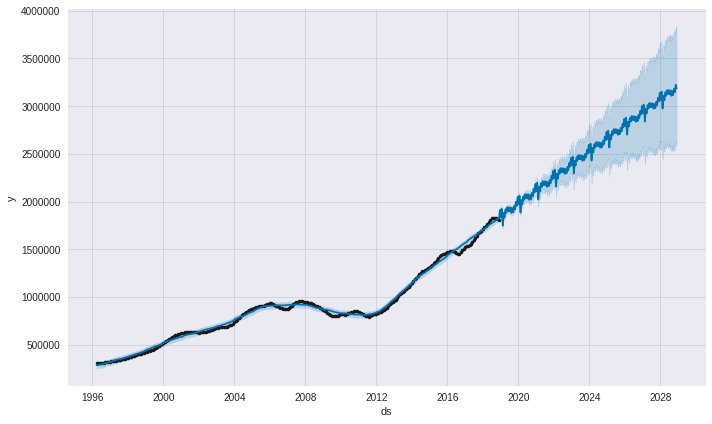

In [0]:
fig1 = m.plot(forecast)

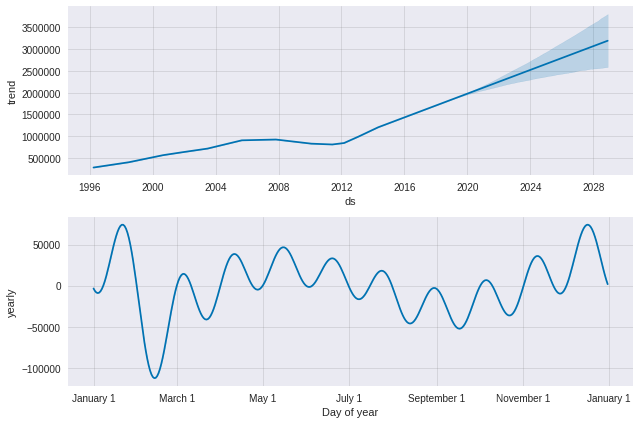

In [0]:
fig2 = m.plot_components(forecast)

### Comparison between Prophet and Linear Regression

<Figure size 7200x3600 with 0 Axes>

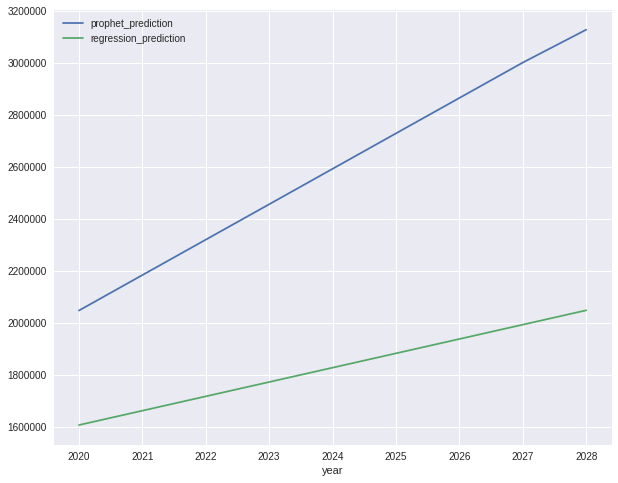

In [0]:
fig = plt.figure(figsize=(100, 50))
df_compare.plot(x = 'year', figsize=(10,8))
plt.show()